## To investigate how offset in parallax space (aka Gaia observations) can affect a simple regress model to infer luminosity from true liminosity (aka stellar spectra, true liminosity information is encoded there)

## This also demonstrate why we are certain of Gaia DR2 parallax generally is way too small because of the unique pattern of the result

This is Gaia DR2 - APOGEE DR14 matched parallax, RA DEC in J2000, parallax in mas
E:\sdss_mirror\dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/allStar-l31c.2.fits was found!


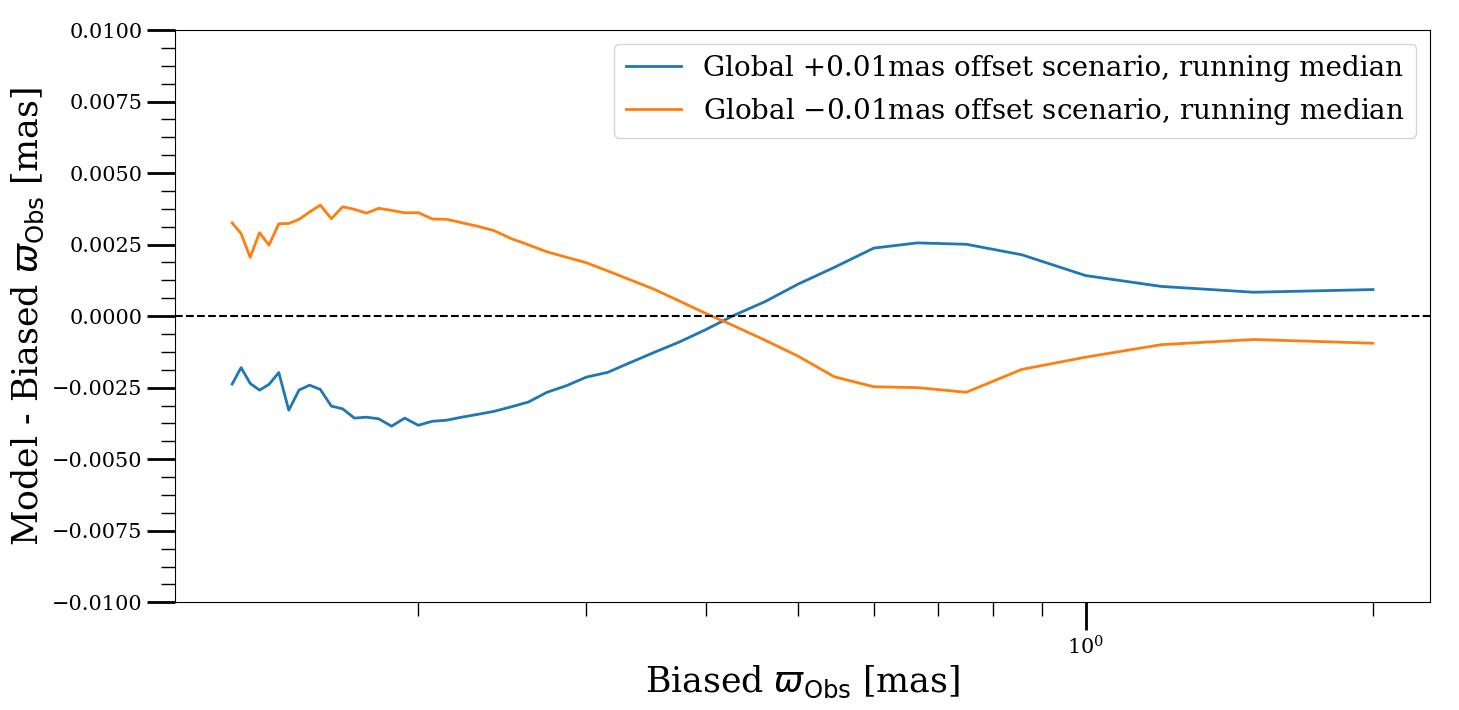

In [4]:
%matplotlib inline
import pylab as plt
import numpy as np
from astropy.io import fits

from astroNN.apogee import allstar
from astroNN.datasets.xmatch import xmatch
from astroNN.gaia import gaiadr2_parallax, mag_to_fakemag, fakemag_to_pc, extinction_correction

plt.rc('font',**{'family': 'serif', 'weight':'medium', 'size':20})

ra, dec, parallax, parallax_error = gaiadr2_parallax(cuts=0.2, keepdims=False, offset=False)
allstar_file = fits.getdata(allstar(dr=14))

idx1, idx2, sep = xmatch(ra, allstar_file['RA'], colRA1=ra, colDec1=dec, colRA2=allstar_file['RA'], colDec2=allstar_file['DEC'])

corrected_K = extinction_correction(allstar_file['K'], allstar_file['AK_TARG'])

parallax_gp005 = parallax + 0.01
parallax_gn005 = parallax - 0.01

fakemag = mag_to_fakemag(corrected_K[idx2], parallax)
fakemag_gp005 = mag_to_fakemag(corrected_K[idx2], parallax_gp005)
fakemag_gn005 = mag_to_fakemag(corrected_K[idx2], parallax_gn005)

# high order polynomial to simulate the behavior of NN
z_fit_gp005 = np.polyfit(fakemag[fakemag>0.], fakemag_gp005[fakemag>0.], 3)
z_fit_gn005 = np.polyfit(fakemag[fakemag>0.], fakemag_gn005[fakemag>0.], 3)

nn_obs_gp005 = 1000 / fakemag_to_pc(np.poly1d(z_fit_gp005)(fakemag), corrected_K[idx2]).value
nn_obs_gn005 = 1000 / fakemag_to_pc(np.poly1d(z_fit_gn005)(fakemag), corrected_K[idx2]).value

# running median basic setting
number_bin = 45
low_dist = 500
high_dist = 8000
median_diff_gp005 = []
median_diff_gn005 = []
median_uncer = []
spaces_dist = np.linspace(low_dist, high_dist, number_bin+1)

for i in range(number_bin):
    idx = [(1000/parallax_gp005<spaces_dist[i+1])&(1000/parallax_gp005>spaces_dist[i])]
    median_diff_gp005.append(np.median(nn_obs_gp005[idx] - parallax_gp005[idx]))
    idx = [(1000/parallax_gn005<spaces_dist[i+1])&(1000/parallax_gn005>spaces_dist[i])]
    median_diff_gn005.append(np.median(nn_obs_gn005[idx] - parallax_gn005[idx]))

plt.figure(figsize=(15, 7.5), dpi=100)
plt.semilogx(1000 / np.array(spaces_dist)[:-1], np.array(median_diff_gp005), alpha=1., lw=2.,
             label='Global +0.01mas offset scenario, running median')
plt.semilogx(1000 / np.array(spaces_dist)[:-1], np.array(median_diff_gn005), alpha=1., lw=2., 
             label='Global '+ '$-$'+'0.01mas offset scenario, running median')
# plt.scatter(parallax_gn005, nn_obs_gn005 - parallax_gn005, s=1., alpha=0.1)
plt.xscale('log')
plt.xlabel(r'Biased $\varpi_{\mathrm{Obs}}$ [mas]', fontsize=25)
plt.ylabel(r'Model - Biased $\varpi_{\mathrm{Obs}}$ [mas]', fontsize=25)
plt.legend(loc='best', fontsize=20)
plt.axhline(0., c='k', ls='--')
plt.ylim(-0.01, 0.01)
plt.minorticks_on()
plt.tick_params(labelsize=15, width=2, length=20, which='major')
plt.tick_params(width=1, length=10, which='minor')
plt.tight_layout()
plt.savefig('initial_offset.pdf')
plt.show()